## Import the package

In [1]:
using LinearAlgebra
using Polynomials
using Oceananigans
using Plots
using FFMPEG
import Random
using Distributions
using NCDatasets
using FFTW
using Polynomials: fit
using MeshGrid

The following function computes the equilibrium points N and P given $\lambda$ and $\nu$

The Polynomial to determine N is: $-\nu^2 N^3 + (\nu^2 N_t -\lambda^2 ) N^2 -2 \lambda^2 N -\lambda^2=0$ with dealth rate $\lambda P^{1/2}$

In [8]:
## The following function computes the equilibrium points N and P
function equilibrium_state(N_t,λ,ν)
                ## record the length of vector N_t
                num_pt=length(N_t)
                # Pre-define the vector P_star and N_star as vector to store the equilibrium values for each N_t[i]
                P̄,N̄=zeros(Float64,num_pt),zeros(Float64,num_pt)

                # running the for loop for every N_t
                for i in 1:num_pt
                   poly_i = Polynomial([λ^2, 2 * λ^2, (λ^2-ν^2 * N_t[i]), ν^2])
                   ## Only consider the real roots of above polynomial for solving N
                   all_roots = roots(poly_i)
                   real_roots = filter(x -> isreal(x), all_roots)
                   real_roots = Float64.(real(real_roots))

                   ## if there is no such real roots in the restricted range [0,N_t[i]], we use -1 to denote N and P
                   if isempty(filter(x -> 0 <= x <= N_t[i], real_roots))
                       N̄[i] = -1
                       P̄[i] = -1
                   else
                       N̄[i] = filter(x -> 0 <= x <= N_t[i], real_roots)[1]
                       P̄[i] = N_t[i] - N̄[i]
                   end
               end
               
               return(N̄,P̄)
end

equilibrium_state (generic function with 1 method)

## Construct system with death rate $\lambda P^{1/2}$

In [9]:
## ODE_PDE_system returns a list with 1st and 2nd column denotes the maximum real part of eigenvalue of ODE and PDE 
## 3rd column of their corresponding N_t position
## 4th column returns the eigen_vector with the eigenvalue of the maximum real part


function ODE_PDE_system(Nₜ,λ,ν,d₁,d₂,k)
                              N̄,P̄=equilibrium_state(Nₜ,λ,ν)
                              result=[]
                              for i in 1:length(Nₜ)
                                  Nᵢ,Pᵢ=N̄[i],P̄[i]
                                  if Nᵢ == -1 && Pᵢ==-1
                                     key=[-0.1,-0.1,Nₜ[i]]
                                  else
                                     ## Define the Jacobian matrix at equilibrium states
                                     A=zeros(2,2)
                                     A=[-ν*Pᵢ/((1+Nᵢ)^2)   -1/2*λ*Pᵢ^(-1/2)
                                         ν*Pᵢ/((1+Nᵢ)^2)   1/2*λ*Pᵢ^(-1/2)]
                                     ## define the linear approximation matrix for PDE system
                                     diffusion_vec=[d₁,d₂]
                                     diffusion_mat=diagm(0 => -(k^2)*diffusion_vec)
                                     pde_mat=A+diffusion_mat
                                     ode_mat=A
                                     eigen_pde=eigen(pde_mat).values
                                     ## define the maximum of real part of eigenvalue
                                     key_eigen_pde = maximum(real(eigen_pde))
                                     max_index= argmax(real(eigen_pde))
            
                                     eigen_ode=eigen(ode_mat).values
                                     key_eigen_ode = maximum(real(eigen_ode))
                                     ## define the eigenvector corresponding to the largest eigenvalue
                                     eigen_vec=(eigen(pde_mat).vectors)[:,max_index]
                                     
                                     key=[key_eigen_ode,key_eigen_pde,Nₜ[i],eigen_vec]
                                     
                                   end
                                   push!(result,key)
                               end
           return(result)
       end

ODE_PDE_system (generic function with 1 method)

## Graphical illustration for characteristic polynomial for differnt k

In [10]:
## Consider visualize the growthrate for different set of parameter:
ν = 2
λ = 0.7
d_1= 1
d_2= 1e-4
N_t=0.1:0.05:2
ODE_PDE_system(N_t,λ,ν,d_1,d_2,1/2)

39-element Vector{Any}:
 [-0.1, -0.1, 0.1]
 [-0.1, -0.1, 0.15]
 [-0.1, -0.1, 0.2]
 [-0.1, -0.1, 0.25]
 [-0.1, -0.1, 0.3]
 [-0.1, -0.1, 0.35]
 [-0.1, -0.1, 0.4]
 [-0.1, -0.1, 0.45]
 [-0.1, -0.1, 0.5]
 [-0.1, -0.1, 0.55]
 ⋮
 Any[0.0, 0.08545368072355347, 1.6, [0.24692471603623528, -0.9690346663615418]]
 Any[0.0, 0.07509408415246943, 1.65, [0.22513657331817297, -0.9743272157517467]]
 Any[0.0, 0.06695492785806029, 1.7, [0.20675699206252504, -0.9783923273581293]]
 Any[0.0, 0.06036101623629561, 1.75, [0.19098558814236985, -0.981592840806163]]
 Any[0.0, 0.05489633371890343, 1.8, [0.1772780391713955, -0.9841608084187996]]
 Any[0.0, 0.05028686125994461, 1.85, [0.16524272934883996, -0.9862529292211739]]
 Any[0.0, 0.046343115753203684, 1.9, [0.15458680147789405, -0.987979210716923]]
 Any[0.0, 0.0429290916122789, 1.95, [0.14508495145535227, -0.9894192017851676]]
 Any[5.551115123125783e-17, 0.03994422695632774, 2.0, [0.13656001244300142, -0.9906317999143615]]

In [11]:
function largest_eigenvalue(d, N_star, P_star)
    k_square = 0:0.1:50
    largest_eigen=zeros(length(k_square))
    for i in 1:length(k_square)
        h = d* k_square[i]^ 2+ (d* 2 * P_star/ ((1 + N_star)^ 2)- 0.7* P_star^(-1/2)* 0.5)* k_square[i]
        b = (d+1)* (k_square[i])- (0.5 * 0.7 * P_star^(-1/2)- 2 * P_star / ((1 + N_star) ^ 2))
        poly = Polynomial([h,b,1])
        roots_poly = roots(poly)
        largest_eigen[i] = maximum(real(roots_poly))
    end
    p=plot(k_square, largest_eigen, label="d = $d", xlabel="k^2", ylabel="Re \\lambda",ylim = (0, 0.4))

    max_eigen = maximum(largest_eigen)
    max_index = argmax(largest_eigen)
    corresponding_k_square = k_square[max_index]
    
    return p,"max_real_eigenvalue" ,max_eigen,"corresponding k value" ,sqrt(corresponding_k_square), "diffusion ratio" ,d
end


largest_eigenvalue (generic function with 1 method)

In [12]:
## The characteristic poly that we are solving is k^4 + b k^4 + h=0
function find_largest_eigenvalue(d, k, N_star, P_star)
    k_square=k^2
    h = d* k_square^ 2+ (d* 2 * P_star/ ((1 + N_star)^ 2)- 0.7* P_star^(-1/2)* 0.5)* k_square
    b = (d+1)* k_square- (0.5 * 0.7 * P_star^(-1/2)- 2 * P_star / ((1 + N_star) ^ 2))
    poly = Polynomial([h,b,1])
    roots_poly = roots(poly)
    largest_eigen = maximum(real(roots_poly))
    
    return "k value", k , "eigen_value", largest_eigen
end

find_largest_eigenvalue (generic function with 1 method)

## Return numeric array for N, P and space, time array

In [13]:
## key_variable_outcome takes the specific file_writer to returns the actual numeric of N, P, Space and time array

function key_variable_outcome(mymodel,file_name)
    space=Array(znodes(mymodel.tracers.N))
    N_timeseries = FieldTimeSeries(file_name, "N")
    P_timeseries = FieldTimeSeries(file_name, "P")
    times=Array(N_timeseries.times)
    N_data = parent(N_timeseries.data[:,:,1:size(space)[1],:])
    P_data = parent(P_timeseries.data[:,:,1:size(space)[1],:])
    N_data = dropdims(N_data, dims=(1, 2))
    P_data = dropdims(P_data, dims=(1, 2))
    return N_data,P_data,times,space
end

key_variable_outcome (generic function with 1 method)

## Make animation on N and P by taking 2 input matrices

In [14]:
## Animation of N
function make_animation_N(N_data,P_data,times,space,time_step)
    
    anim_N = @animate for t in 1:time_step:size(N_data, 2)
        plot(space, N_data[:, t],ylim=(N̄-0.15,N̄+0.15),label="N")
        time=times[t]
        title!("Time: $time")
    end
    
    mp4(anim_N, "D:/Master Research/N_animation.mp4", fps=20)

end
    

make_animation_N (generic function with 1 method)

In [15]:
## Animation of P
function make_animation_P(N_data,P_data,times,space,time_step)
    anim_P = @animate for t in 1:time_step:size(P_data, 2)
        plot(space, P_data[:, t],ylim=(P̄-0.1,P̄+0.1),label="P")
        time=times[t]
        title!("Time: $time")
    end
    
    mp4(anim_P, "D:/Master Research/P_animation.mp4", fps=20)

end
    

make_animation_P (generic function with 1 method)

## Make a NP conservation plot over time

In [16]:
## Conservation plot over time
function conservation_plot(N_data,P_data,times,space)
    ## pre-define a vector to record the total concentration over time
    total_con = sum(N_data, dims=1) .+ sum(P_data, dims=1)
    total_con_vector = vec(total_con)
    # Plot the row sums against the time vector
    plot(times, total_con_vector, xlabel="Time", ylabel="sum con over time", title="total concentration over time",ylim=(180,190),label="total population")
end

conservation_plot (generic function with 1 method)

## surface plot

In [17]:
## Surface plot
function surface_plot(N_data,P_data,times,space)
    N_plot=surface(times, space, N_data ,xlabel="Time", ylabel="Space")
    P_plot=surface(times, space, P_data ,xlabel="Time", ylabel="Space")

    plot(N_plot, P_plot, layout=(1, 2),size=(1200, 800))
end

surface_plot (generic function with 1 method)

## Calculate the e-folding time:

In [18]:
## E_folding time
function e_folding_time(data_mat_N,data_mat_P,times,space,N_star,P_star)
    time_array_N = Float64[]
    push!(time_array_N,times[1])
    perturb_N=maximum(abs.(data_mat_N[:,1].-N_star))
    
    for t in 2:size(times)[1]
        if maximum(abs.(data_mat_N[:,t].-N_star)) >= exp(1)*perturb_N
           push!(time_array_N,times[t])
           perturb_N=maximum(abs.(data_mat_N[:,t].-N_star))
        end
    end


    time_array_P = Float64[]
    push!(time_array_P,times[1])
    perturb_P=maximum(abs.(data_mat_P[:,1].-P_star))
    
    for t in 2:size(times)[1]
        if maximum(abs.(data_mat_P[:,t].-P_star)) >= exp(1)*perturb_P
           push!(time_array_P,times[t])
           perturb_P=maximum(abs.(data_mat_P[:,t].-P_star))
        end
    end

    time_array_N=diff(time_array_N)
    time_array_P=diff(time_array_P)

    time_axis_N=range(0, stop=length(time_array_N), length=length(time_array_N))
    time_axis_P=range(0, stop=length(time_array_P), length=length(time_array_P))

    e_folding_N=1 ./time_array_N
    e_folding_P=1 ./time_array_P
    
    myplot_N = scatter(time_axis_N, e_folding_N, xlabel="Time", ylabel="Growth Rate", title="E-folding N", label="N", legend=:bottomright, color=:blue)
    plot!(myplot_N, time_axis_N, e_folding_N, label="", line=:solid, color=:blue)
    ylims!(0, maximum(e_folding_N)+0.1)
    
    myplot_P = scatter(time_axis_P, e_folding_P, xlabel="Time", ylabel="Growth Rate", title="E-folding P", label="P", legend=:bottomright, color=:blue)
    plot!(myplot_P, time_axis_P, e_folding_P, label="", line=:solid, color=:red)
    ylims!(0, maximum(e_folding_P)+0.1)

    
    return e_folding_N,e_folding_P,myplot_N,myplot_P
end

e_folding_time (generic function with 1 method)

In [19]:
## Calculate the Growth rate depending on our simulation
function experiment_growth_rate(file_name)
    ds = NCDataset(file_name, "r")
    times = ds["time"][:]

    ## Denote the perturbation for N and P from the equilibrium state
    N′ = ds["perturbation_N"]
    P′ = ds["perturbation_P"]
    I = 2000:4000
    
    degree = 1

    ## Fit the log of growth with line on time range I for N,P
    
    linear_fit_N = fit(times[I], log.(N′[I]), degree, var = :t)
    best_fit_N = @. exp(linear_fit_N[0] + linear_fit_N[1] * times)
    
    linear_fit_P = fit(times[I], log.(P′[I]), degree, var = :t)
    best_fit_P = @. exp(linear_fit_P[0] + linear_fit_P[1] * times)

    print("Growth rate of N is approximately ", linear_fit_N[1], "\n")
    print("Growth rate of P is approximately ", linear_fit_P[1], "\n")


    plot(times, N′,label="norm(N′)", yscale = :log10, linestyle=:solid,
    lw=4, xlabel="time", ylabel="norm",title="Norm of perturbations", legend=:topleft)

    plot!(times, P′,label="norm(P′)", linestyle=:solid, lw=4)#
    
    plot!(times, best_fit_N,label="N best fit", linestyle=:dash, lw=4)
    
    plot!(times, best_fit_P,label="P best fit", linestyle=:dash, lw=4)

end
    
    

experiment_growth_rate (generic function with 1 method)

## Calculates the FFT power of each Mode

In [60]:
## Heatmap for power of each mode
function FFT_power(N_data, P_data, times)
    rev_N_data=reverse(N_data, dims=1)
    N_data_mat=vcat(rev_N_data, N_data)
    fft_coeff_N_data=zeros(size(N_data_mat))

    mode_values = (1:41 .- 1) / 2

    rev_P_data=reverse(P_data, dims=1)
    P_data_mat=vcat(rev_P_data, P_data)
    fft_coeff_P_data=zeros(size(P_data_mat))

    for i in 1:size(P_data_mat)[2]
        fft_coeff_P_data[:,i]=abs.(fft(P_data_mat[:,i])).^2
        fft_coeff_N_data[:,i]=abs.(fft(N_data_mat[:,i])).^2
    end
    
    yticks_values = 2:2:40
    N_plot=heatmap(times, mode_values, fft_coeff_N_data[2:41,:], xlabel="Time", ylabel="Modes", title="Power of N",yticks=(yticks_values, string.(yticks_values)))
    P_plot=heatmap(times, mode_values, fft_coeff_P_data[2:41,:], xlabel="Time", ylabel="Modes", title="Power of P",yticks=(yticks_values, string.(yticks_values)))

    plot(N_plot, P_plot, layout=(1, 2),size=(1200, 500))

end
    

FFT_power (generic function with 1 method)

## Initialize the model

In [22]:
## Initialize the model
d=1e-4

NP_parameters =   (d_1=1 ,
                   d_2= d ,
                   ν = 2 ,          
                   λ = 0.7
)



growth(z, t, N, P, params) = params.ν * P * N / (N + 1)
death(z,t,N,P,params)=params.λ*(max(0, P))^(1/2)


N_reaction(z, t, N, P,  params) = - growth( z, t, N, P,  params) + death(z,t,N,P,params)
P_reaction(z, t, N, P, params) =   growth( z, t, N, P, params)  - death(z,t,N,P,params)


N_forcing = Forcing(N_reaction, field_dependencies = (:N, :P), parameters = NP_parameters)
P_forcing = Forcing(P_reaction, field_dependencies = (:N, :P ), parameters = NP_parameters)


grid    = RectilinearGrid(size=128, z=(0,2*π), topology=(Flat, Flat, Bounded))

diffusivities = NamedTuple{(:N, :P)}((NP_parameters.d_1, NP_parameters.d_2))

closure = ScalarDiffusivity(κ=diffusivities)

model   = NonhydrostaticModel(; grid, 
                             closure, 
                             tracers = (:N, :P),
                             forcing = (N=N_forcing, P=P_forcing)
                             )

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 1×1×128 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Centered(order=2)
├── tracers: (N, P)
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=(N=1.0, P=0.0001))
├── buoyancy: Nothing
└── coriolis: Nothing

## Calculate some neccessary Hyper-parameter, $N_t$, N_Star, P_Star and eigen_vector

In [23]:
λ,ν=0.7,2
N̄=equilibrium_state(1.45,λ,ν)[1][1]
P̄=equilibrium_state(1.45,λ,ν)[2][1];

## Graph Visualization for possible k values

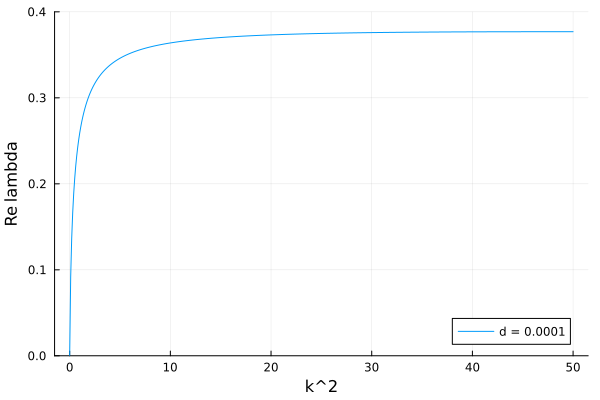

In [24]:
p,_=largest_eigenvalue(0.0001, N̄, P̄)
display(p)

## Initial Conditions

Below Block is used to calculate only one mode k

In [25]:
## Pre-define the mode number k
k=7

function N_initial_cond(x)
    C₁=ODE_PDE_system(1.45,λ,ν,1,d,k)[1][4][1]
    N = N̄+1e-4*C₁*cos(k*x)
    return(N)
end


function P_initial_cond(x)
    C₂=ODE_PDE_system(1.45,λ,ν,1,d,k)[1][4][2]
    P = P̄+1e-4*C₂*cos(k*x)
    return(P)
end

P_initial_cond (generic function with 1 method)

Below Block is used to calculate multiple modes pre-defined by k_vec

In [26]:
## Pre-define the mode vector k
k_vec=[3,7]

function N_IC_general(x,k_vec)
    C_vec=zeros(length(k_vec))
    N=N̄
    for i in 1:length(C_vec)
        C_vec[i]=ODE_PDE_system(1.45,λ,ν,1,d,k_vec[i])[1][4][1]
        N=N+1e-4*C_vec[i]*cos(k_vec[i]*x)
    end
    return(N)
end

function N_IC_gen(x)
    N=N_IC_general(x,k_vec)
    return(N)
end


function P_IC_general(x,k_vec)
    C_vec=zeros(length(k_vec))
    P=P̄
    for i in 1:length(C_vec)
        C_vec[i]=ODE_PDE_system(1.45,λ,ν,1,d,k_vec[i])[1][4][2]
        P=P+1e-4*C_vec[i]*cos(k_vec[i]*x)
    end
    return(P)
end

function P_IC_gen(x)
    P=P_IC_general(x,k_vec)
    return(P)
end

P_IC_gen (generic function with 1 method)

Random initial condition for N and P

In [27]:
function random_IC_N(x)
    noise = rand(Normal(0, 1e-3))
    return N̄ + noise
end

function random_IC_P(x)
    noise = rand(Normal(0, 1e-3))
    return P̄ + noise
end

random_IC_P (generic function with 1 method)

## setting up model

In [28]:
set!(model, N = N_IC_gen, P = P_IC_gen)
min_Δz = minimum_zspacing(model.grid)
diffusion_time_scale = min_Δz^2 / model.closure.κ.N

0.0024095713869847065

## Run Simulation

In [29]:
## Running simulation
max_time=60
simulation = Simulation(model, Δt = 0.1 * diffusion_time_scale, stop_time = max_time)

########################################

N, P = model.tracers

perturbation_N(args...) = norm(N .- N̄)
perturbation_P(args...) = norm(P .- P̄)

simulation.output_writers[:growth_NP] =
    NetCDFOutputWriter(model, (; perturbation_N, perturbation_P);
                     filename = "NPgrowthrandom.nc",
                     schedule = IterationInterval(10),
                     dimensions = (; perturbation_N = (),
                                     perturbation_P = ()),
                     overwrite_existing = true)

simulation.output_writers[:fields] =
    JLD2OutputWriter(model, model.tracers,
                     filename = "NP.jld2",
                     schedule=IterationInterval(200),
                     overwrite_existing = true)

run!(simulation)

┌ Warning: Overwriting existing d:\Master Research\Research-Project\NPgrowthrandom.nc.
└ @ Oceananigans.OutputWriters C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\OutputWriters\netcdf_output_writer.jl:397
┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:195
┌ Info:     ... simulation initialization complete (3.765 seconds)
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:239
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:123
┌ Info:     ... initial time step complete (2.450 seconds).
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:132
┌ Info: Simulation is stopping after running for 16.354 minutes.
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\s

## Sample Simulation

In [30]:
find_largest_eigenvalue(1e-4,3,N̄,P̄)

("k value", 3, "eigen_value", 0.36171658472430696)

In [31]:
find_largest_eigenvalue(1e-4,7,N̄,P̄)

("k value", 7, "eigen_value", 0.3768508582387311)

In [32]:
N_data,P_data,times,space=key_variable_outcome(model,"NP.jld2");

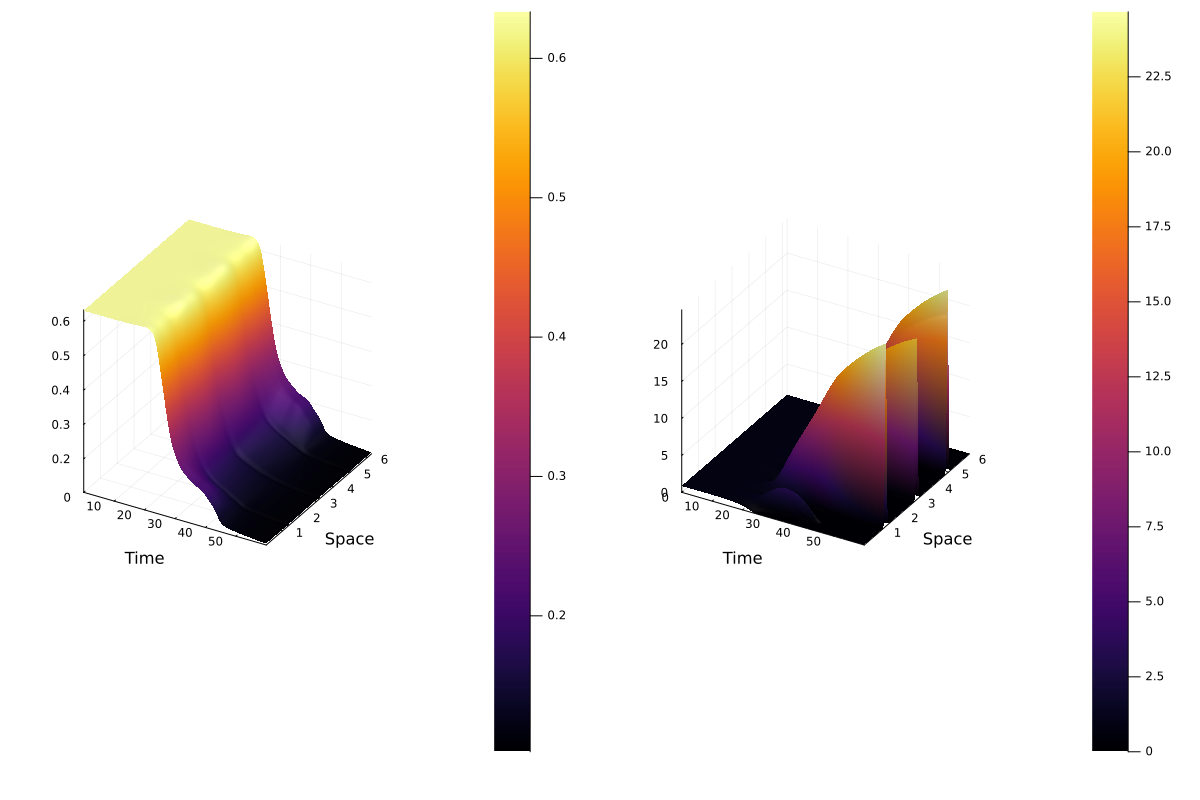

In [33]:
surface_plot(N_data,P_data,times,space)

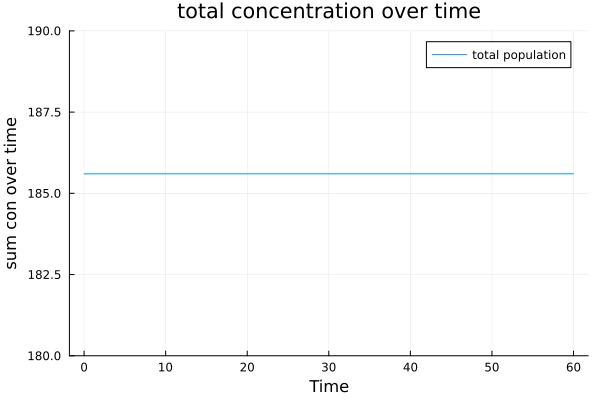

In [34]:
conservation_plot(N_data,P_data,times,space)

Growth rate of N is approximately 0.3624244316237205
Growth rate of P is approximately 0.3700992412027756


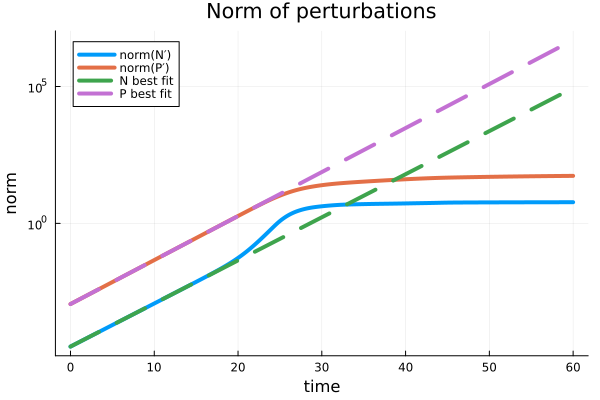

In [35]:
experiment_growth_rate("NPgrowthrandom.nc")

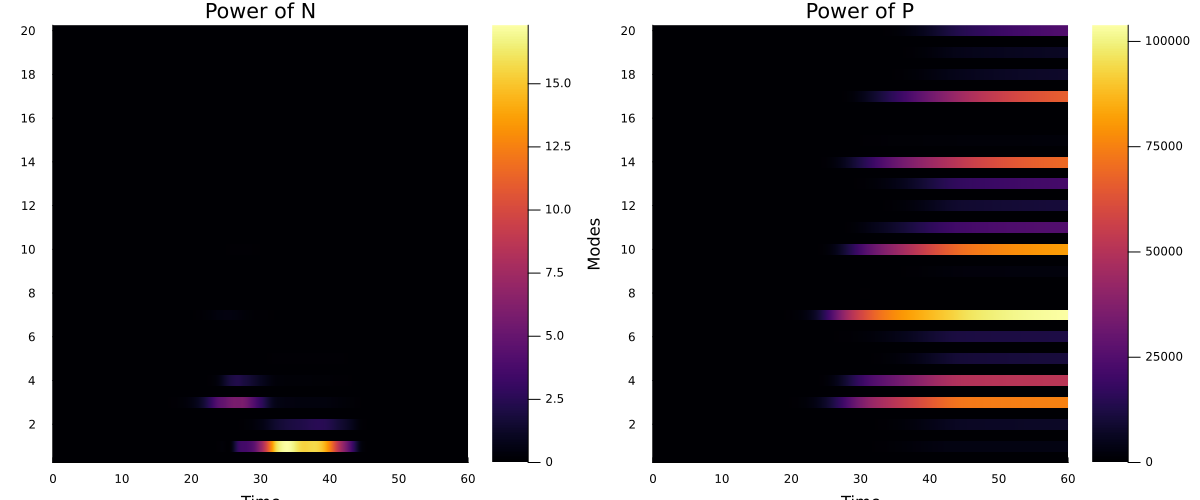

In [61]:
FFT_power(N_data, P_data, times)